In this script we will make a quality control of the scRNA data.


In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid.inset_locator import inset_axes

from parameters import *

import warnings

warnings.filterwarnings("ignore")

import sys
sys.path.append('../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot

/tmp/ipykernel_212/2490405870.py:5: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
adata = scp.read("Data/Raw.h5ad")

# QC measures <a name="QC"></a>

For each well, we compute the following QC measures:

 1. #UMIs counted per well
 2. #Genes counter per well
 3. Fraction of mitrochondrial gene counts

In [3]:
mtgenes = ["mt-" in i for i in adata.var["gene_name"]]
scttools.qc_metrics(adata,mtgenes)

## Bulk statistics <a name="Bulk"></a>

First we check the statistics in terms of the bulk dataset and set hard thresholds for sectioning the data.

From the gene histogram and the scatter plot, the data show a bimodality that can be seen as a sift in the number of number of genes expressed. Appart from this bimodality there does not appear to be outliers with high counts that could indicate the presence of clear doublets, which is consistent with the fact that the experimental method in general has very low rate rate of doublets. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


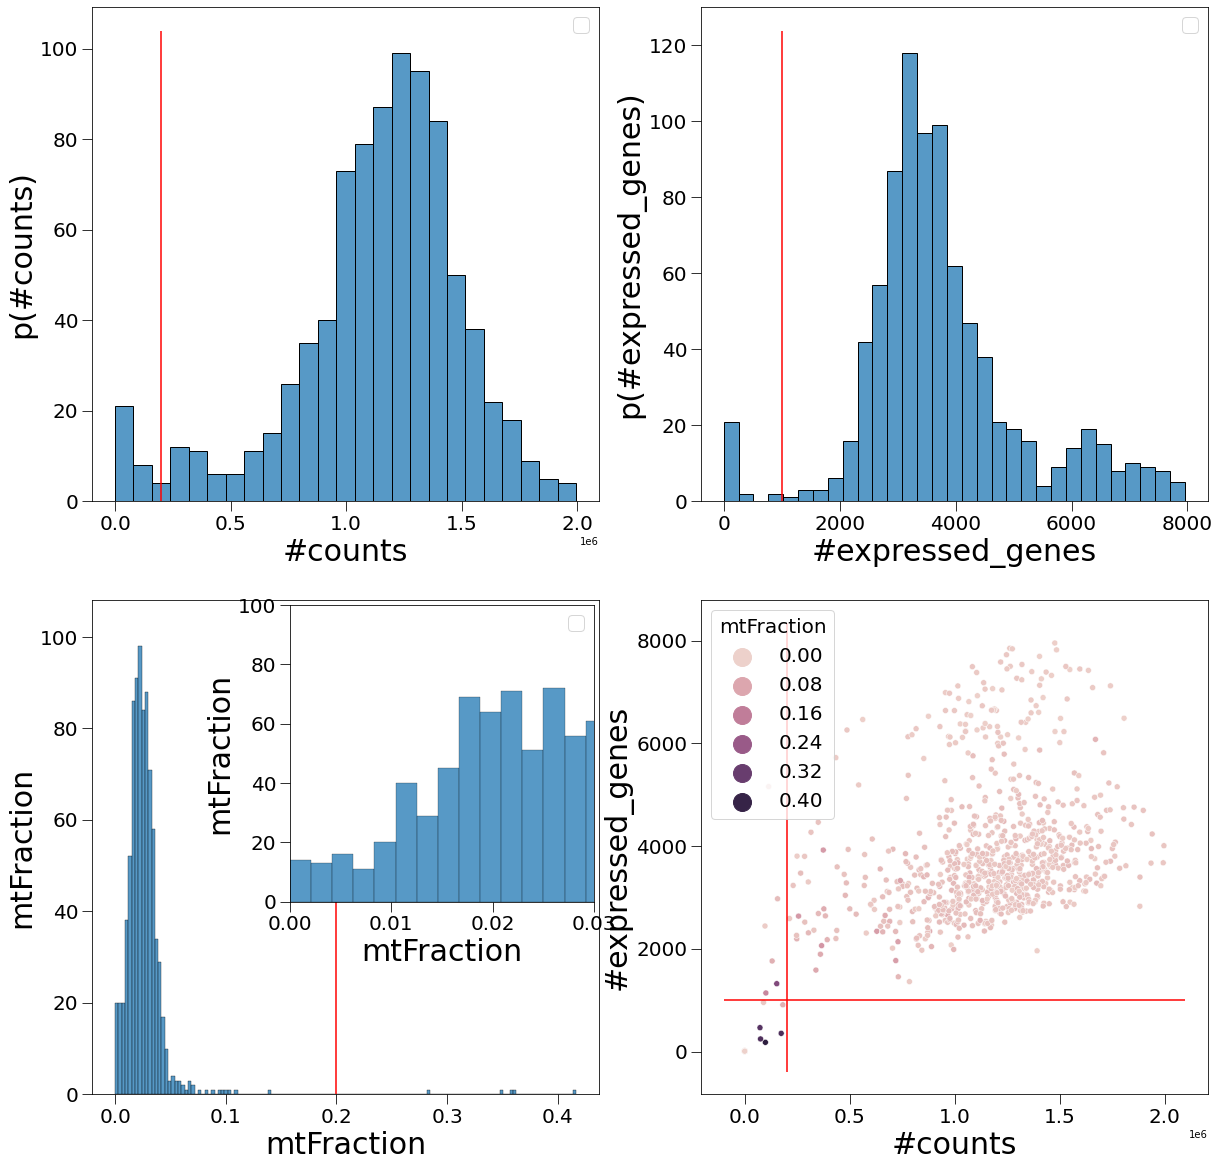

In [4]:
fig,ax = plt.subplots(2,2,figsize=[20,20])

sns.histplot(data=adata.obs,x="#counts",ax=ax[0,0])
sctplot.plot_base(ax[0,0],labels=["#counts","p(#counts)"])
sctplot.vline(ax[0,0],COUNTS_MIN,color="r")

sns.histplot(data=adata.obs,x="#expressed_genes",ax=ax[0,1])
sctplot.plot_base(ax[0,1],labels=["#expressed_genes","p(#expressed_genes)"])
sctplot.vline(ax[0,1],GENES_MIN,color="r")

sns.histplot(data=adata.obs,x="mtFraction",ax=ax[1,0])
sctplot.plot_base(ax[1,0],labels=["mtFraction","mtFraction"])
sctplot.vline(ax[1,0],MTFRACTION_MAX,color="r")
subax = inset_axes(ax[1,0],
                    width="60%",
                    height="60%",
                    loc="upper right")
sns.histplot(data=adata.obs,x="mtFraction",bins=200,ax=subax)
sctplot.plot_base(subax,labels=["mtFraction","mtFraction"],axis=[0,0.03,0,100])
sctplot.vline(subax,MTFRACTION_MAX,color="r")

sns.scatterplot(data=adata.obs,y="#expressed_genes",x="#counts",hue="mtFraction",ax=ax[1,1])
sctplot.plot_base(ax[1,1],labels=["#counts","#expressed_genes"],legend_markerscale=3,legend_title="mtFraction")
sctplot.hline(ax[1,1],GENES_MIN,color="r")
sctplot.vline(ax[1,1],COUNTS_MIN,color="r")

fig.savefig(DIRECTORY+"Plots/QC_global.pdf",bbox_inches="tight",transparent=True)
fig.show()

## By tag conditions <a name="Tag"></a>

We now check the statistics by conditions:

 1. Time events
 2. Biological condition
 3. Plate
 4. Sample
 
 Several observations can be made:
 
  1. The bimodality comes from cells at stage 120hr. These cells show systematically more genes expressed.
  2. "Black" tag corresponds to cells that the cytometer has considered to have given an error when depositing a cell, because it put two, did not have a measured or some other sort of error.
  3. "Empty" tagged droplets show consistently a lower number of genes and UMI expressed except for the presence of some outlier. This cells seem tagged consistently as empty.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


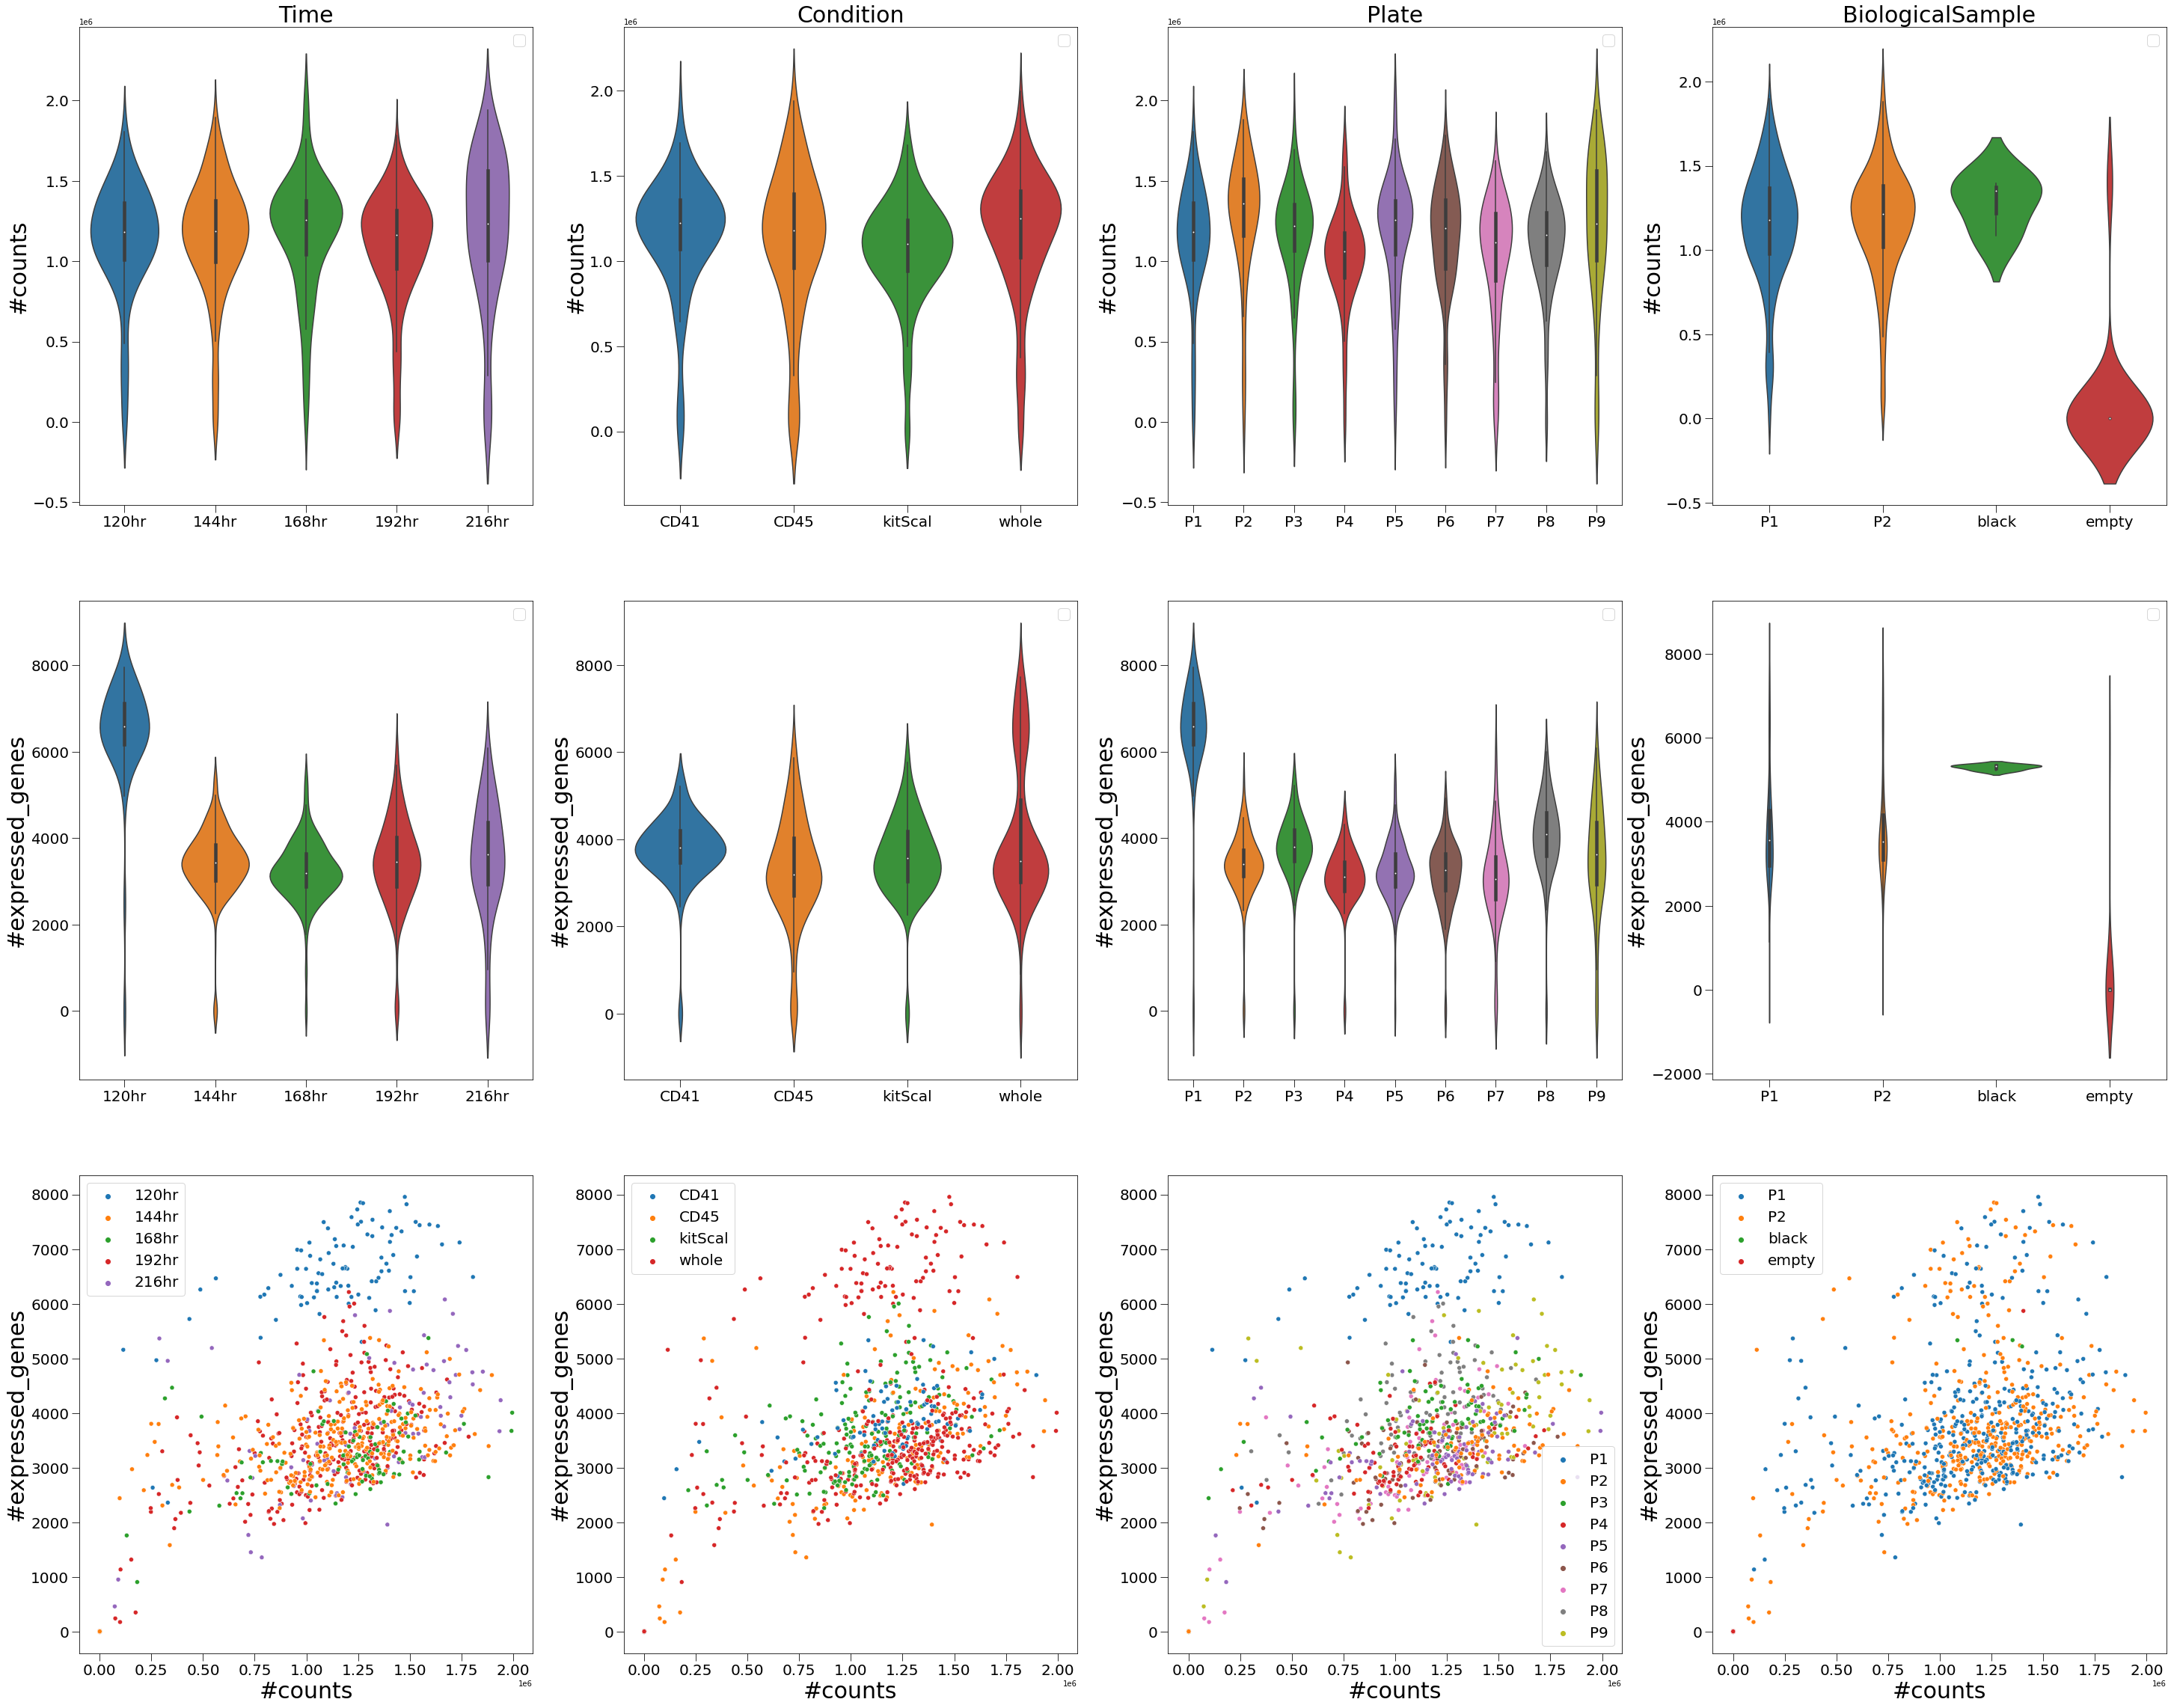

In [5]:
fig,ax = plt.subplots(3,4,figsize=[50,40])

for i,tag in enumerate(["Time","Condition","Plate","BiologicalSample"]):
    sns.violinplot(data=adata.obs,x=tag,y="#counts",ax=ax[0,i])
    sctplot.plot_base(ax[0,i],labels=["","#counts"],title=tag)
    sns.violinplot(data=adata.obs,x=tag,y="#expressed_genes",ax=ax[1,i])
    sctplot.plot_base(ax[1,i],labels=["","#expressed_genes"],title="")
    sns.scatterplot(data=adata.obs,x="#counts",y="#expressed_genes",hue=tag,ax=ax[2,i])
    sctplot.plot_base(ax[2,i],labels=["#counts","#expressed_genes"],title="")

fig.savefig(DIRECTORY+"Plots/QC_tags.pdf",bbox_inches="tight",transparent=True)
fig.show()

# Measures with error in the flow cytometer <a name="Measures"></a>

We can observe that the measures that do not have any flow cytommetry measure are cells that seem valid cells. We can further observe that there is one well declared as empty that has robably populated with a valid cell. This is consistent with the outlier tail in the sample violin plot. 

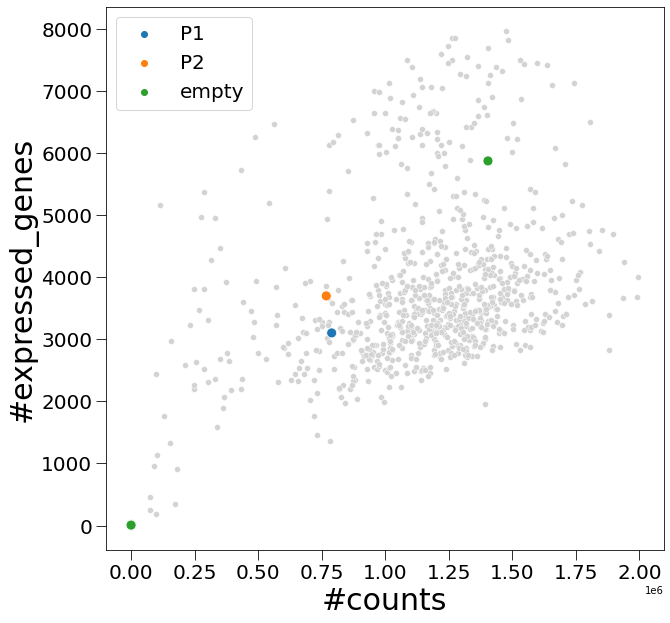

In [6]:
fig,ax = plt.subplots(figsize=[10,10])

sns.scatterplot(data=adata[np.invert(adata.obs["FSC-A"].isna())].obs,x="#counts",y="#expressed_genes",color="lightgrey",ax=ax)
sns.scatterplot(data=adata[adata.obs["FSC-A"].isna()].obs,x="#counts",y="#expressed_genes",s=100,hue="BiologicalSample",ax=ax)
sctplot.plot_base(ax,labels=["#counts","#expressed_genes"])

plt.savefig(DIRECTORY+"Plots/QC_no_flow_measure_scatter.pdf",bbox_inches="tight",transparent=True)
fig.show()

No handles with labels found to put in legend.


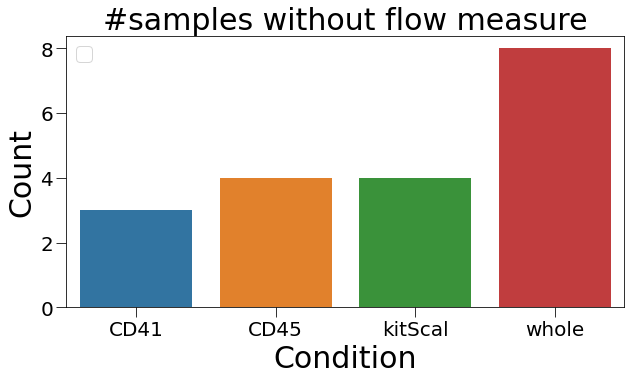

In [7]:
fig,ax = plt.subplots(figsize=[10,5])

sns.countplot(data=adata[adata.obs["FSC-A"].isna()].obs,x="Condition",ax=ax)
sctplot.plot_base(ax,labels=["Condition","Count"],title="#samples without flow measure")

fig.savefig(DIRECTORY+"Plots/QC_no_flow_measure.pdf",bbox_inches="tight",transparent=True)
fig.show()

# Filter cells and save <a name="Filter"></a>

From the quality control we will remove all cells with the following characteristics:

 1. Cells that not follow the hard threshold conditions
 2. Cells that were tagged as "empty", even the one that could be a valid cell
 3. Cells that where tagged as "black" as being possible doublets
 
A further note, since the experimental method has a very reduced amount of doublets. We assume that the rest of the wells correspond to true cells and we will not explore it further. Current methods for doublet removal will not be effective in such small dataset.

In [8]:
retained, summary = scttools.filter_cells(adata,
            ("#counts",COUNTS_MIN,np.Inf),
            ("#expressed_genes",GENES_MIN,np.Inf),
            ("mtFraction",0,MTFRACTION_MAX),
            ("BiologicalSample",["P1","P2"]) #originally we kept empty as well
            )

summary

,Object,#below,%below,#above,%above,Total_removed,%Total_removed
0,obs.#counts,31,0.036131,0,0.0,31,0.036131
1,obs.#expressed_genes,25,0.029138,0,0.0,25,0.029138
2,obs.mtFraction,7,0.008159,12,0.013986,12,0.013986
3,obs.BiologicalSample,0,0,0,0,20,0.02331
4,TOTAL_,0,0,0,0,35,0.040793


In [9]:
adata = adata[retained]
adata.write(DIRECTORY+"Results/QC.h5ad")